In [1]:
import os
import sys
import json
import ipaddress
import numpy as np
from torch import nn
from sklearn.model_selection import train_test_split

class Resource:
  def __init__(self, RequestID, Site, LoadURL, LoadDomain, 
      Type, MimeType, RemoteIPAddr, ModTime):
    self.request_id = RequestID
    self.site = Site
    self.load_url = LoadURL
    self.load_domain = LoadDomain
    self.resource_type = Type
    self.mimetype = MimeType
    self.ip_addr = RemoteIPAddr
    self.mod_time = ModTime

# Function to parse and create Resources from JSON
def extract_from_JSON(filename):
    ip_to_occurrences = dict()
    ip_to_sites = dict()
    site_date_ipset = dict()
    with open(filename) as f:
        for line in f:
            data = json.loads(line)
            resource = Resource(data["RequestID"], data["Site"], data["LoadURL"], 
                                data["LoadDomain"], data["Type"], data["MimeType"], 
                                data["RemoteIPAddr"], data["ModTime"])
            
            # For ip occurrence filtering in entire dataset
            ip_to_occurrences.setdefault(resource.ip_addr, set())
            occurrence_event = resource.mod_time + " " + resource.site
            ip_to_occurrences[resource.ip_addr].add(occurrence_event)
    
            # For ips unique to a website
            ip_to_sites.setdefault(resource.ip_addr, set())
            ip_to_sites[resource.ip_addr].add(resource.site)
            
            # extracting samples
            site_date_ipset.setdefault(resource.site, dict())
            site_date_ipset[resource.site].setdefault(resource.mod_time, set())
            site_date_ipset[resource.site][resource.mod_time].add(resource.ip_addr)
    return ip_to_occurrences, ip_to_sites, site_date_ipset

In [2]:
filename = "../output/02-06-2020_1000-recurring_output.json"
ip_to_occurrences, ip_to_sites, site_date_ipset = extract_from_JSON(filename)

In [3]:
print(len(site_date_ipset), len(ip_to_occurrences), len(ip_to_sites))

974 54622 54622


In [4]:
# filtering passes: 
ips_to_remove = set()
for ip in ip_to_occurrences:
    occurrences = ip_to_occurrences[ip]
    if len(occurrences) < 20:
       ips_to_remove.add(ip)

for ip in ips_to_remove:
    try:
        del ip_to_occurrences[ip]
        del ip_to_sites[ip]
    except KeyError:
        print(ip, " Not Present")
     
unique_ip_to_site = dict()
# Does it make sense to filter the site out?
for ip in ip_to_sites:
    if len(ip_to_sites[ip]) == 1:
        site = ip_to_sites[ip].pop()
        unique_ip_to_site[ip] = site
        try:
            del site_date_ipset[site]
        except KeyError:
            pass
            #print(site, " Not Present in map")
        try:
            del ip_to_occurrences[ip]
        except KeyError:
            pass
            #print(ip, " Not Present")

# ip_to_occurrences holds all ips after filtering

In [5]:
print(len(site_date_ipset))

193


In [6]:
# create site to encoded ipset mapping
labels = []
encodings = []
all_ips = list(ip_to_occurrences.keys())
print(len(all_ips))
for site in site_date_ipset:
    date_to_ipset = site_date_ipset[site]
    for date in date_to_ipset:
        ipset = date_to_ipset[date]
        iparray = [0] * len(all_ips)
        for ip in ipset:
            if ip in ip_to_occurrences:
                iparray[all_ips.index(ip)] = 1
        labels.append(site)
        encodings.append(np.asarray(iparray))

print(len(labels), len(encodings))
                

9760
20786 20786


In [7]:
import pyasn
asndb = pyasn.pyasn('pyasn')
asn_set = set()
ip_to_asn = dict()
for ip in ip_to_occurrences:
    try:
        asn,_= asndb.lookup(ip)
        ip_to_asn[ip] = asn
        asn_set.add(asn)
    except:
        print(ip, " not mapped to asn")
        continue

  not mapped to asn


In [8]:
sites_asn = []
asn_enc = []
asn_list = list(asn_set)
for site in site_date_ipset:
    date_to_ipset = site_date_ipset[site]
    for date in date_to_ipset:
        ipset = date_to_ipset[date]
        asn_array = [0]*len(asn_list)
        for ip in ipset:
            if ip in ip_to_occurrences:
                try:
                    asn_array[asn_list.index(ip_to_asn[ip])] = 1
                except Exception as e:
                    continue
        sites_asn.append(site)
        asn_enc.append(np.asarray(asn_array))

In [9]:
print(len(sites_asn[0]), len(asn_enc[0]))
print(len(labels[0]), len(encodings[0]))

1 346
1 9760


In [10]:
import torch.nn.functional as F
class NNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(NNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 400)
#         self.fc2 = nn.Linear(400, 100)
        self.fc3 = nn.Linear(400, output_size)
    
    def forward(self, x):
        x = self.fc1(x)
#         x = self.fc2(x)
        return self.fc3(x)

In [11]:
from sklearn import preprocessing
import torch

tensor_encodings = torch.Tensor(encodings)
le_labels = preprocessing.LabelEncoder()
tensor_labels = le_labels.fit_transform(labels)
tensor_labels = torch.as_tensor(tensor_labels)

tensor_asn_enc = torch.Tensor(asn_enc)
le_asn = preprocessing.LabelEncoder()
tensor_sites_asn = le_asn.fit_transform(sites_asn)
tensor_sites_asn = torch.as_tensor(tensor_sites_asn)

In [12]:
import torch.utils.data as data

ip_dataset = data.TensorDataset(tensor_encodings,tensor_labels)
asn_dataset = data.TensorDataset(tensor_asn_enc,tensor_sites_asn)

In [13]:
batch_size = 64
validation_split = .2
# shuffle_dataset = True
shuffle_dataset = False
# random_seed= 42

In [14]:
train_size = int(0.8 * len(asn_dataset))
test_size = len(asn_dataset) - train_size
asn_train_dataset, asn_test_dataset = torch.utils.data.random_split(asn_dataset, [train_size, test_size])
asn_train_loader = torch.utils.data.DataLoader(asn_train_dataset, batch_size=batch_size, shuffle=True)
asn_test_loader = torch.utils.data.DataLoader(asn_test_dataset, batch_size=batch_size, shuffle=True)
print(len(asn_train_loader.dataset), len(asn_test_loader.dataset))

16628 4158


In [15]:
train_size = int(0.8 * len(ip_dataset))
test_size = len(ip_dataset) - train_size
ip_train_dataset, ip_test_dataset = torch.utils.data.random_split(ip_dataset, [train_size, test_size])
ip_train_loader = torch.utils.data.DataLoader(ip_train_dataset, batch_size=batch_size, shuffle=True)
ip_test_loader = torch.utils.data.DataLoader(ip_test_dataset, batch_size=batch_size, shuffle=True)
print(len(ip_train_loader.dataset), len(ip_test_loader.dataset))

16628 4158


In [16]:
print (len(ip_train_loader)) 
print (len(ip_test_loader))

260
65


In [17]:
input_size_ipdataset = len(tensor_encodings[0])
output_size_ipdataset = len(site_date_ipset)
embed_size_ipdataset = 1000

input_size_asndataset = len(tensor_asn_enc[0])
output_size_asndataset = len(site_date_ipset)
embed_size_asndataset = 270
print(input_size_ipdataset, output_size_ipdataset)
print(input_size_asndataset, output_size_asndataset)

9760 193
346 193


In [18]:
model_ip = NNet(input_size_ipdataset, output_size_ipdataset)
model_asn = NNet(input_size_asndataset, output_size_asndataset)

In [19]:
criterion = nn.CrossEntropyLoss(reduction='mean')
optimizer_ip = torch.optim.SGD(model_ip.parameters(), lr=0.5)
optimizer_asn = torch.optim.SGD(model_asn.parameters(), lr=0.5)

In [20]:
len(ip_test_loader.dataset)

4158

In [21]:
# Reference: https://github.com/hunkim/PyTorchZeroToAll

from torch.autograd import Variable
from sklearn.metrics import confusion_matrix
import time
device = 'cpu'

def confusion_mat(preds, labels, conf_matrix, labels_to_predicted):
    preds = torch.argmax(preds, 1)
    for p, t in zip(preds, labels):
        t_class = le_labels.classes_[t.item()]
        p_class = le_labels.classes_[p.item()]
        labels_to_predicted.setdefault(t_class, set())
        labels_to_predicted[t_class].add(p_class)
        conf_matrix[p, t] += 1
    
    return conf_matrix

def train(epoch, train_loader, model, optimizer):
    model.train()
    total_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        total_loss += loss.item() 
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} | Batch Status: {}/{} ({:.0f}%) | Loss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return total_loss / len(train_loader)

def test(test_loader, model, conf_matrix, labels_to_predicted):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        conf_matrix = confusion_mat(output, target, conf_matrix, labels_to_predicted)
        # sum up batch loss
        test_loss += criterion(output, target).item()
        # get the index of the max
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader)
    print(f'===========================\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} '
          f'({100. * correct / len(test_loader.dataset):.0f}%)')
    return test_loss
    
    

In [22]:
# first ip dataset training and tests
since = time.time()
labels_to_predicted_ip = dict()
print(len(ip_train_loader.dataset), len(ip_test_loader.dataset))
conf_matrix_ip = torch.zeros(output_size_ipdataset, output_size_ipdataset)
train_losses, test_losses = [], []
for epoch in range(1, 10):
    epoch_start = time.time()
    epoch_train_loss = train(epoch, ip_train_loader, model_ip, optimizer_ip)
    train_losses.append(epoch_train_loss)
    m, s = divmod(time.time() - epoch_start, 60)
    print(f'Training time: {m:.0f}m {s:.0f}s')
    epoch_test_loss = test(ip_test_loader, model_ip, conf_matrix_ip, labels_to_predicted_ip)
    test_losses.append(epoch_test_loss)
    m, s = divmod(time.time() - epoch_start, 60)
    print(f'Testing time: {m:.0f}m {s:.0f}s')

m, s = divmod(time.time() - since, 60)
print(f'Total Time: {m:.0f}m {s:.0f}s\nModel was trained on {device}!')

print("conf mat ip: ", conf_matrix_ip)

16628 4158
Train Epoch: 1 | Batch Status: 0/16628 (0%) | Loss: 5.262933
Train Epoch: 1 | Batch Status: 640/16628 (4%) | Loss: 5.208053
Train Epoch: 1 | Batch Status: 1280/16628 (8%) | Loss: 5.109070
Train Epoch: 1 | Batch Status: 1920/16628 (12%) | Loss: 5.119896
Train Epoch: 1 | Batch Status: 2560/16628 (15%) | Loss: 5.075325
Train Epoch: 1 | Batch Status: 3200/16628 (19%) | Loss: 4.862082
Train Epoch: 1 | Batch Status: 3840/16628 (23%) | Loss: 4.745239
Train Epoch: 1 | Batch Status: 4480/16628 (27%) | Loss: 4.747589
Train Epoch: 1 | Batch Status: 5120/16628 (31%) | Loss: 4.305937
Train Epoch: 1 | Batch Status: 5760/16628 (35%) | Loss: 4.477897
Train Epoch: 1 | Batch Status: 6400/16628 (38%) | Loss: 4.385164
Train Epoch: 1 | Batch Status: 7040/16628 (42%) | Loss: 3.794909
Train Epoch: 1 | Batch Status: 7680/16628 (46%) | Loss: 3.707959
Train Epoch: 1 | Batch Status: 8320/16628 (50%) | Loss: 3.671799
Train Epoch: 1 | Batch Status: 8960/16628 (54%) | Loss: 3.683164
Train Epoch: 1 | Batc

Train Epoch: 5 | Batch Status: 8960/16628 (54%) | Loss: 1.431458
Train Epoch: 5 | Batch Status: 9600/16628 (58%) | Loss: 1.340435
Train Epoch: 5 | Batch Status: 10240/16628 (62%) | Loss: 1.766811
Train Epoch: 5 | Batch Status: 10880/16628 (65%) | Loss: 1.484206
Train Epoch: 5 | Batch Status: 11520/16628 (69%) | Loss: 1.747385
Train Epoch: 5 | Batch Status: 12160/16628 (73%) | Loss: 1.555034
Train Epoch: 5 | Batch Status: 12800/16628 (77%) | Loss: 1.250396
Train Epoch: 5 | Batch Status: 13440/16628 (81%) | Loss: 1.460290
Train Epoch: 5 | Batch Status: 14080/16628 (85%) | Loss: 1.373568
Train Epoch: 5 | Batch Status: 14720/16628 (88%) | Loss: 1.500419
Train Epoch: 5 | Batch Status: 15360/16628 (92%) | Loss: 1.724037
Train Epoch: 5 | Batch Status: 16000/16628 (96%) | Loss: 1.377383
Training time: 0m 12s
Test set: Average loss: 1.4767, Accuracy: 2430/4158 (58%)
Testing time: 0m 14s
Train Epoch: 6 | Batch Status: 0/16628 (0%) | Loss: 1.058382
Train Epoch: 6 | Batch Status: 640/16628 (4%) | 

In [23]:
# Now asn dataset training and tests
since = time.time()
criterion = nn.CrossEntropyLoss(reduction='mean')
print(len(asn_train_loader.dataset), len(asn_test_loader.dataset))
conf_matrix = torch.zeros(output_size_ipdataset, output_size_ipdataset)
labels_to_predicted_asn = dict()

for epoch in range(1, 10):
    epoch_start = time.time()
    train(epoch, asn_train_loader, model_asn, optimizer_asn)
    m, s = divmod(time.time() - epoch_start, 60)
    print(f'Training time: {m:.0f}m {s:.0f}s')
    test(asn_test_loader, model_asn, conf_matrix, labels_to_predicted_asn)
    m, s = divmod(time.time() - epoch_start, 60)
    print(f'Testing time: {m:.0f}m {s:.0f}s')

m, s = divmod(time.time() - since, 60)
print(f'Total Time: {m:.0f}m {s:.0f}s\nModel was trained on {device}!')
print("conf mat asn: ", conf_matrix)

16628 4158
Train Epoch: 1 | Batch Status: 0/16628 (0%) | Loss: 5.268534
Train Epoch: 1 | Batch Status: 640/16628 (4%) | Loss: 5.218261
Train Epoch: 1 | Batch Status: 1280/16628 (8%) | Loss: 5.134067
Train Epoch: 1 | Batch Status: 1920/16628 (12%) | Loss: 5.055423
Train Epoch: 1 | Batch Status: 2560/16628 (15%) | Loss: 4.951707
Train Epoch: 1 | Batch Status: 3200/16628 (19%) | Loss: 4.657314
Train Epoch: 1 | Batch Status: 3840/16628 (23%) | Loss: 4.556238
Train Epoch: 1 | Batch Status: 4480/16628 (27%) | Loss: 4.467766
Train Epoch: 1 | Batch Status: 5120/16628 (31%) | Loss: 4.252181
Train Epoch: 1 | Batch Status: 5760/16628 (35%) | Loss: 4.196016
Train Epoch: 1 | Batch Status: 6400/16628 (38%) | Loss: 4.033747
Train Epoch: 1 | Batch Status: 7040/16628 (42%) | Loss: 3.780418
Train Epoch: 1 | Batch Status: 7680/16628 (46%) | Loss: 4.026907
Train Epoch: 1 | Batch Status: 8320/16628 (50%) | Loss: 3.637241
Train Epoch: 1 | Batch Status: 8960/16628 (54%) | Loss: 3.395622
Train Epoch: 1 | Batc

Train Epoch: 5 | Batch Status: 9600/16628 (58%) | Loss: 1.886937
Train Epoch: 5 | Batch Status: 10240/16628 (62%) | Loss: 1.723304
Train Epoch: 5 | Batch Status: 10880/16628 (65%) | Loss: 1.356240
Train Epoch: 5 | Batch Status: 11520/16628 (69%) | Loss: 1.915927
Train Epoch: 5 | Batch Status: 12160/16628 (73%) | Loss: 1.856673
Train Epoch: 5 | Batch Status: 12800/16628 (77%) | Loss: 1.919719
Train Epoch: 5 | Batch Status: 13440/16628 (81%) | Loss: 1.912907
Train Epoch: 5 | Batch Status: 14080/16628 (85%) | Loss: 2.097015
Train Epoch: 5 | Batch Status: 14720/16628 (88%) | Loss: 2.264786
Train Epoch: 5 | Batch Status: 15360/16628 (92%) | Loss: 1.879247
Train Epoch: 5 | Batch Status: 16000/16628 (96%) | Loss: 1.342970
Training time: 0m 4s
Test set: Average loss: 1.9449, Accuracy: 1896/4158 (46%)
Testing time: 0m 6s
Train Epoch: 6 | Batch Status: 0/16628 (0%) | Loss: 2.547005
Train Epoch: 6 | Batch Status: 640/16628 (4%) | Loss: 1.723330
Train Epoch: 6 | Batch Status: 1280/16628 (8%) | Los

In [24]:
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes, name, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

#     fmt = '.2f'
#     thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(name+str(datetime.date(datetime.now()))+".png")
    plt.show()

In [25]:
def print_conf_mat_info(conf_matrix, n_classes, labels):
    TP = conf_matrix.diag()
    for c in range(n_classes):
        idx = torch.ones(n_classes).bool()
        idx[c] = 0
        TN = conf_matrix[idx.nonzero()[:,None], idx.nonzero()].sum()
        FP = conf_matrix[c, idx].sum()
        FN = conf_matrix[idx, c].sum()

        sensitivity = (TP[c] / (TP[c]+FN))
        specificity = (TN / (TN+FP))

        print('Class {}\nTP {}, TN {}, FP {}, FN {}'.format(
            labels[c], TP[c], TN, FP, FN))
        print('Sensitivity = {}'.format(sensitivity))
        print('Specificity = {}'.format(specificity))

Class !
TP 0.0, TN 37422.0, FP 0.0, FN 0.0
Sensitivity = nan
Specificity = 1.0
Class 163.com
TP 0.0, TN 37404.0, FP 0.0, FN 18.0
Sensitivity = 0.0
Specificity = 1.0
Class 3c.tmall.com
TP 52.0, TN 37156.0, FP 104.0, FN 110.0
Sensitivity = 0.32098764181137085
Specificity = 0.9972087740898132
Class 4399.com
TP 180.0, TN 37205.0, FP 37.0, FN 0.0
Sensitivity = 1.0
Specificity = 0.9990065097808838
Class 45eijvhgj2.com
TP 25.0, TN 37083.0, FP 114.0, FN 200.0
Sensitivity = 0.1111111119389534
Specificity = 0.996935248374939
Class 49oa3o49b6.com
TP 66.0, TN 36948.0, FP 294.0, FN 114.0
Sensitivity = 0.36666667461395264
Specificity = 0.9921056628227234
Class 52pojie.cn
TP 186.0, TN 37225.0, FP 8.0, FN 3.0
Sensitivity = 0.9841269850730896
Specificity = 0.9997851252555847
Class addthis.com
TP 198.0, TN 37224.0, FP 0.0, FN 0.0
Sensitivity = 1.0
Specificity = 1.0
Class adexchangegate.com
TP 152.0, TN 37251.0, FP 0.0, FN 19.0
Sensitivity = 0.8888888955116272
Specificity = 1.0
Class amazon.com
TP 187.0,

Class google.com.vn
TP 8.0, TN 37053.0, FP 90.0, FN 271.0
Sensitivity = 0.02867383509874344
Specificity = 0.9975769519805908
Class google.cz
TP 15.0, TN 36787.0, FP 383.0, FN 237.0
Sensitivity = 0.0595238097012043
Specificity = 0.9896959662437439
Class google.de
TP 1.0, TN 37115.0, FP 100.0, FN 206.0
Sensitivity = 0.004830917809158564
Specificity = 0.9973129034042358
Class google.dz
TP 5.0, TN 37179.0, FP 18.0, FN 220.0
Sensitivity = 0.02222222276031971
Specificity = 0.9995160698890686
Class google.es
TP 43.0, TN 36983.0, FP 178.0, FN 218.0
Sensitivity = 0.16475096344947815
Specificity = 0.9952100515365601
Class google.fr
TP 27.0, TN 37027.0, FP 170.0, FN 198.0
Sensitivity = 0.11999999731779099
Specificity = 0.9954297542572021
Class google.gr
TP 7.0, TN 37171.0, FP 80.0, FN 164.0
Sensitivity = 0.04093567281961441
Specificity = 0.9978523850440979
Class google.hu
TP 44.0, TN 36906.0, FP 246.0, FN 226.0
Sensitivity = 0.16296295821666718
Specificity = 0.9933785796165466
Class google.it
TP 

Confusion matrix, without normalization
tensor([[  0.,   0.,   0.,  ...,   0.,   0.,   0.],
        [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
        [  0.,   0.,  52.,  ...,   0.,   0.,   0.],
        ...,
        [  0.,   0.,   0.,  ..., 126.,   0.,   0.],
        [  0.,   0.,   0.,  ...,   0., 148.,   0.],
        [  0.,   0.,   0.,  ...,   0.,   0., 171.]])


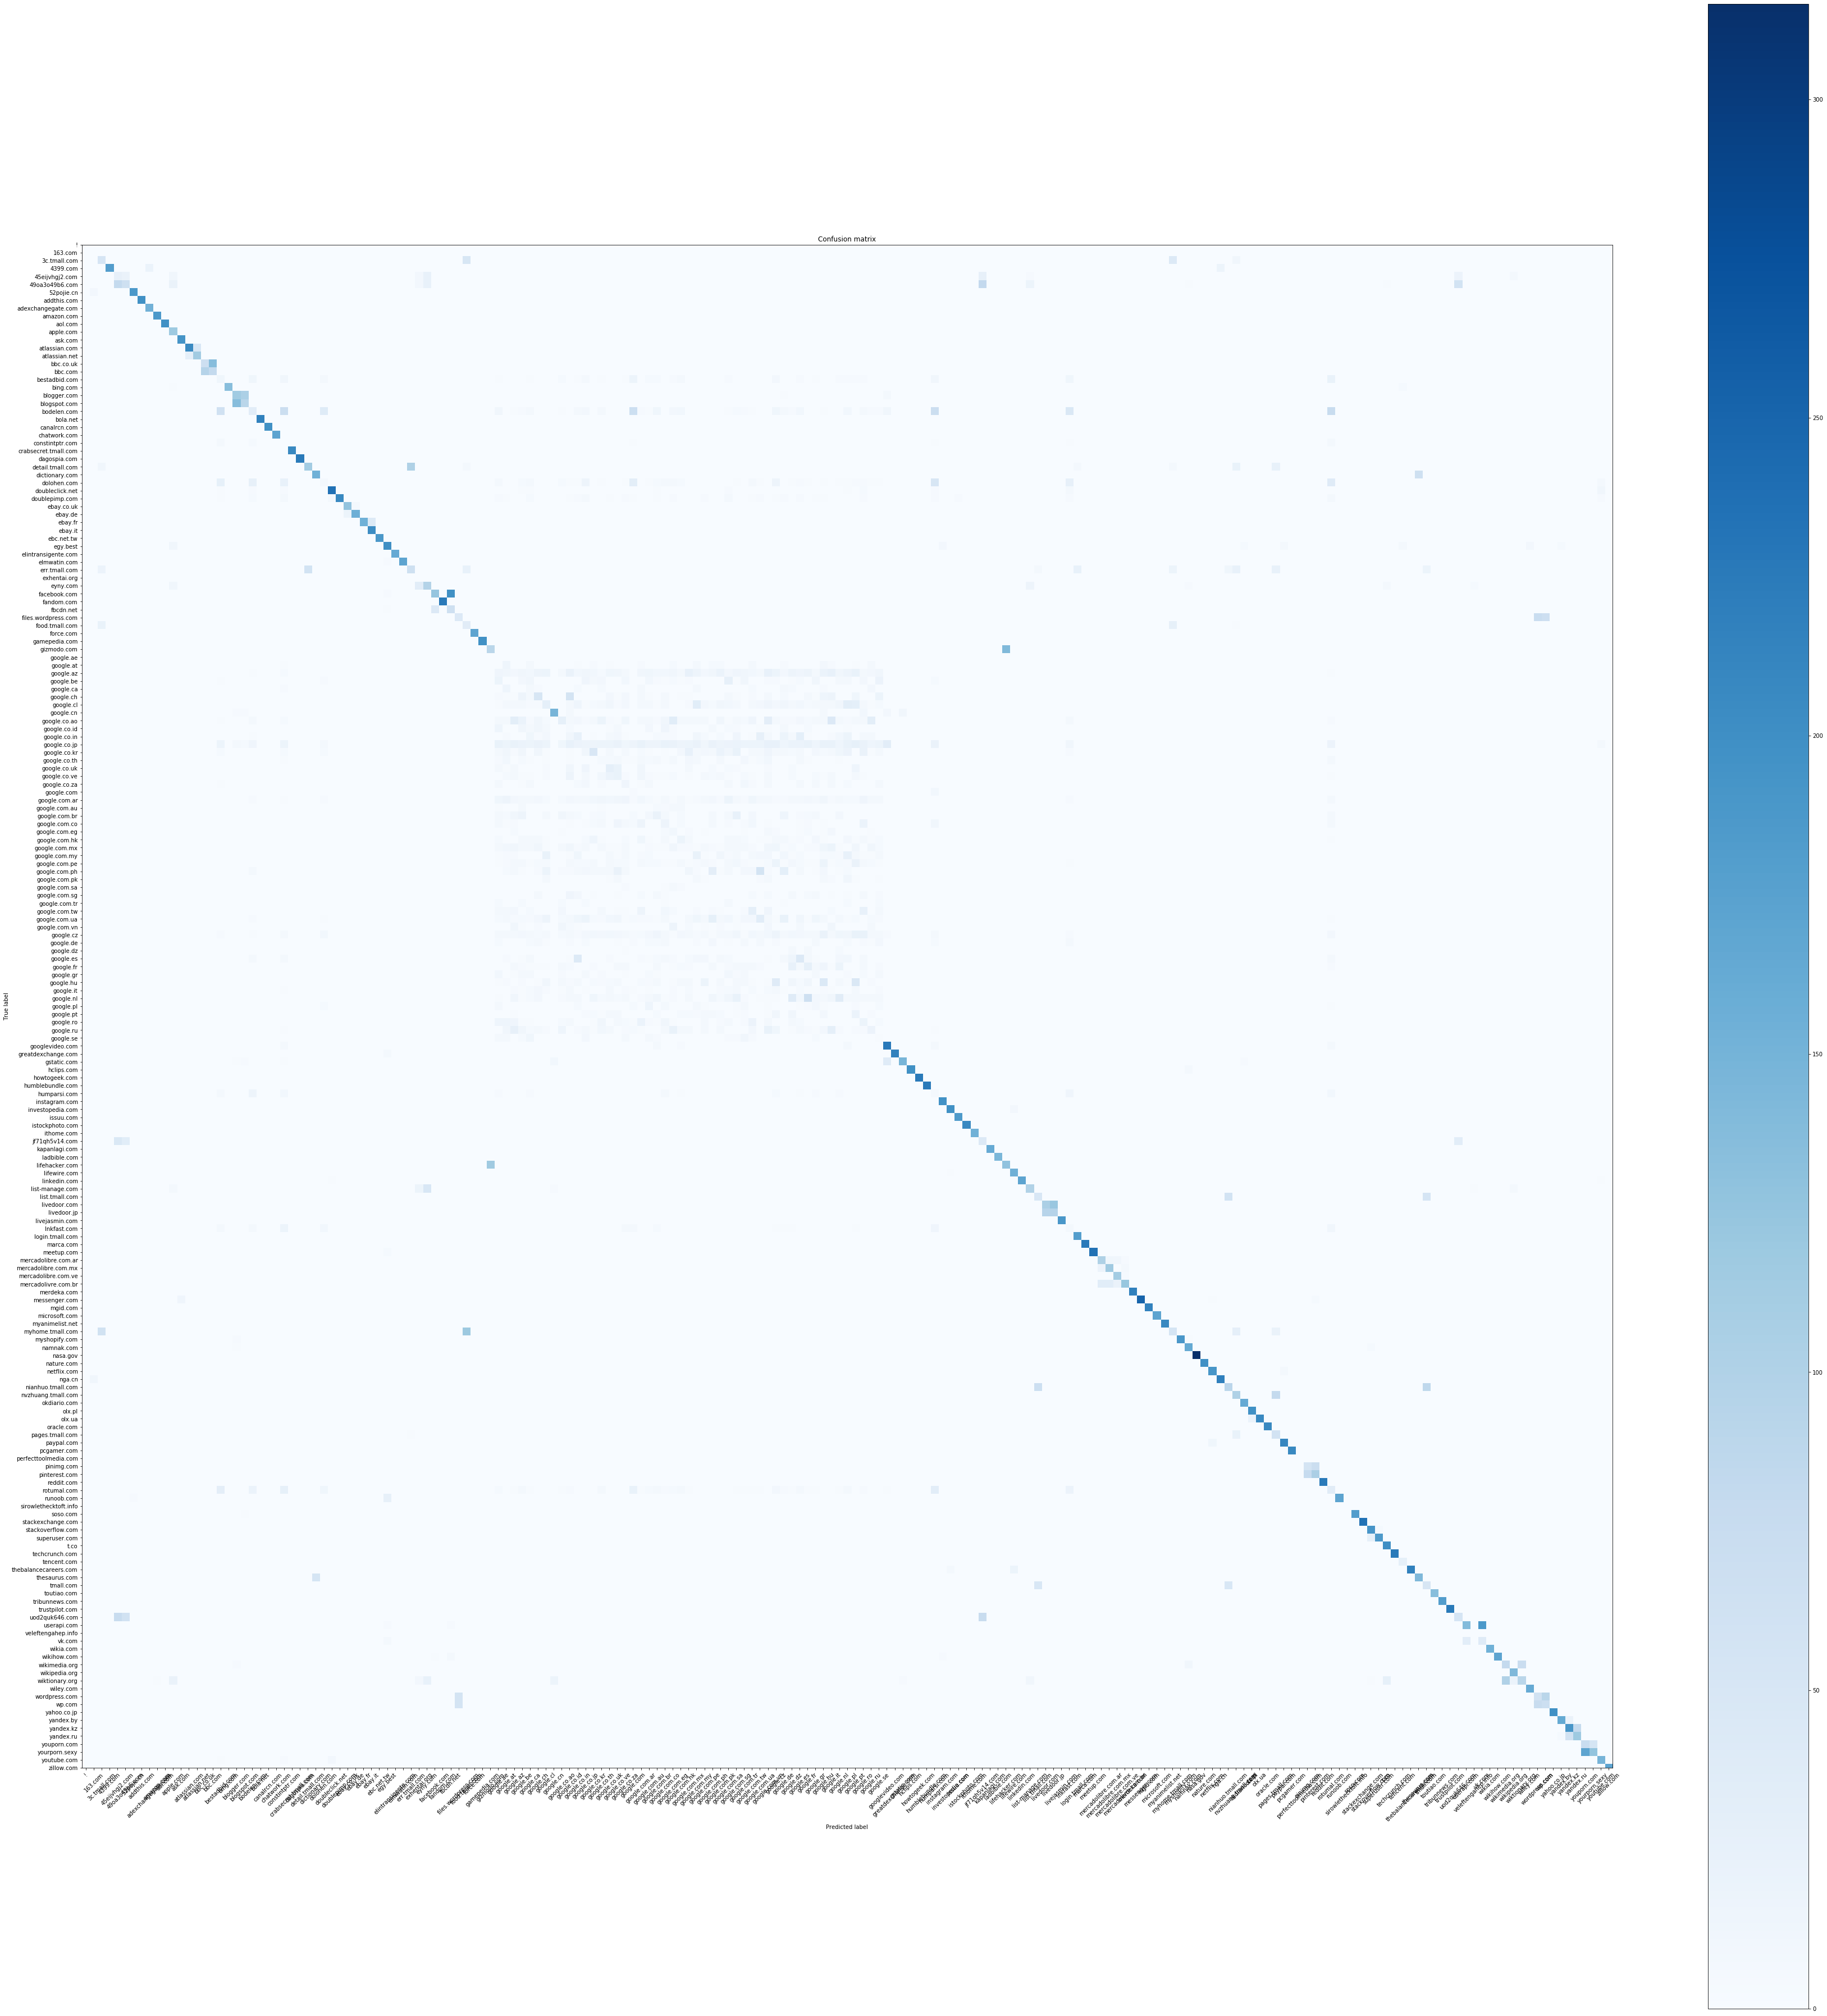

In [26]:
import itertools
print_conf_mat_info(conf_matrix_ip, output_size_ipdataset, le_labels.classes_)
print(le_labels.classes_, len(le_labels.classes_))
fig = plt.gcf()
fig.set_size_inches(50, 50)
fig.savefig("ip"+str(datetime.date(datetime.now()))+".png", dpi=100)
plot_confusion_matrix(conf_matrix_ip, le_labels.classes_, "ip", False)

In [27]:
print(conf_matrix_ip.diag())

tensor([  0.,   0.,  52., 180.,  25.,  66., 186., 198., 152., 187., 198., 118.,
        192., 206., 114.,  67.,  80.,  12., 135., 115.,  90.,  32., 216., 198.,
        171.,   1., 207., 225., 113., 153.,   6., 236., 207., 127., 156., 153.,
        202., 188., 200., 162., 171.,  66.,   0.,  96., 125., 225.,  64.,  42.,
         35., 171., 198.,  91.,   0.,  14.,   8.,   8.,   7.,  50.,  28., 148.,
         26.,   4.,  23.,  15.,  47.,   4.,  28.,  22.,  13.,   3.,   9.,   0.,
         20.,  15.,   9.,  17.,   3.,  21.,   6.,  30.,   1.,   0.,   1.,   1.,
         28.,  33.,   8.,  15.,   1.,   5.,  43.,  27.,   7.,  44.,   2.,  35.,
          1.,  19.,  17.,  18.,   2., 226., 216., 147., 197., 225., 225.,   7.,
        196., 198., 185., 207., 153.,  43., 162., 144., 129., 155., 171.,  99.,
         48., 105.,  95., 189.,   5., 179., 225., 234., 101., 116., 113., 122.,
        216., 252., 215., 171., 207.,  53., 189., 163., 315., 198., 190., 217.,
         89., 101., 162., 197., 207., 20

In [28]:
print(labels_to_predicted_ip)

{'vk.com': {'userapi.com', 'vk.com'}, 'google.com.vn': {'google.ro', 'google.com.hk', 'doublepimp.com', 'google.pt', 'google.com.eg', 'google.com.sg', 'google.cz', 'google.it', 'google.ru', 'google.co.in', 'google.com.ar', 'google.com.mx', 'google.co.za', 'google.com.vn', 'google.co.ao', 'google.nl', 'google.ch', 'google.com.pe', 'google.cl', 'google.com.pk', 'google.com.my', 'google.az', 'google.com.tw', 'google.co.th', 'google.com.ua', 'google.com.ph', 'google.co.uk', 'google.co.kr', 'google.be', 'google.com.co', 'google.es', 'google.hu', 'google.co.jp', 'google.co.ve', 'google.com.sa', 'google.co.id', 'google.pl'}, 'namnak.com': {'hclips.com', 'myshopify.com', '49oa3o49b6.com', 'eyny.com', 'wiktionary.org', 'namnak.com', 'wikimedia.org'}, 'blogger.com': {'blogspot.com', 'myshopify.com', 'blogger.com', 'gstatic.com', 'google.cn', 'namnak.com', 'wikimedia.org', 'google.co.jp', 'soso.com'}, 'google.co.jp': {'google.se', 'google.com.hk', 'doublepimp.com', 'google.pt', 'google.com.eg', '

In [ ]:
fig = plt.gcf()
fig.set_size_inches(50, 50)
fig.savefig("asn"+str(datetime.date(datetime.now()))+".png", dpi=100)
plot_confusion_matrix(conf_matrix, le_labels.classes_, "asn", False)

Confusion matrix, without normalization
tensor([[  0.,   0.,   0.,  ...,   0.,   0.,   0.],
        [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
        [  0.,   0.,  43.,  ...,   0.,   0.,   0.],
        ...,
        [  0.,   0.,   0.,  ...,  54.,   0.,   0.],
        [  0.,   0.,   0.,  ...,   0.,  80.,   0.],
        [  0.,   0.,   0.,  ...,   0.,   0., 234.]])


In [ ]:
print(labels_to_predicted_asn)

In [ ]:
import json

for key in labels_to_predicted_ip:
    labels_to_predicted_ip[key] = list(labels_to_predicted_ip[key])
    
for key in labels_to_predicted_asn:
    labels_to_predicted_asn[key] = list(labels_to_predicted_asn[key])
    
with open('ip'+str(datetime.date(datetime.now()))+".json", 'w') as json_file:
  json.dump(labels_to_predicted_ip, json_file)

with open('asn'+str(datetime.date(datetime.now()))+".json", 'w') as json_file:
  json.dump(labels_to_predicted_asn, json_file)